# Heuristics for Machine Learning Pipeline

**Author**: Miguel Xochicale [@mxochicale](https://github.com/mxochicale)     
**Contributors**: Nhat Phung Tran Huy [@huynhatd13](https://github.com/huynhatd13); Hamideh Kerdegari [@hamidehkerdegari](https://github.com/hamidehkerdegari);  Alberto Gomez [@gomezalberto](https://github.com/)  


## History
* June2022: Adding multiple plots  

## Summary
This notebook presents a learning pipeline to classify 4 chamber view from echocardiography datasets.

### How to run the notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server  
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
### References
* "Proposed Regulatory Framework for Modifications to Artificial Intelligence/Machine Learning (AI/ML)-Based Software as a Medical Device (SaMD) - Discussion Paper and Request for Feedback". https://www.fda.gov/media/122535/download 




# Jupyter Notebook

## 1. Setting imports and datasets paths

In [1]:
import os
import sys
import argparse
import yaml
from pathlib import Path
import json

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from IPython.display import HTML #to be used with HTML(animation.ArtistAnimation().to_jshtml())
from tqdm import tqdm
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchinfo import summary
from torchvision import transforms, utils, models

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
from source.models.learning_misc import train_loop, test_loop#, basicVGGNet
from source.helpers.various import concatenating_YAML_via_tags, plot_dataset_classes, split_train_validate_sets

HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]

REPOSITORY_PATH='repositories/echocardiography'
FULL_REPO_PATH = HOME_PATH+'/'+REPOSITORY_PATH
FULL_REPO_MODEL_PATH = HOME_PATH +'/' + REPOSITORY_PATH + '/models'
CONFIG_FILES_PATH= REPOSITORY_PATH + '/scripts/config_files/users_paths_files'
YML_FILE =  'config_users_paths_files_username_' + USERNAME + '.yml'
FULL_PATH_FOR_YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, YML_FILE)
PATH_for_temporal_files = os.path.join(HOME_PATH, 'datasets/vital-us/echocardiography/temporal-files')

## Setting TRAINING_CURVES_PATH
#CURRENT_PATH=os.path.abspath(os.getcwd())
RESULTS_PATH='scripts/learning-pipeline/results/1st-tests'
TRAINING_CURVES_PATH = os.path.join(FULL_REPO_PATH, RESULTS_PATH)

## Setting FULL_PATH_FOR_YML_FILE
yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler
with open(FULL_PATH_FOR_YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)

## Printing Versions and paths
print(f'PyTorch Version: {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')    
print(f'Pandas Version: {pd.__version__}')
print(f'seaborn Version: {sns.__version__}')
print(f'FULL_PATH_FOR_YML_FILE: {FULL_PATH_FOR_YML_FILE}' )
print(f'TRAINING_CURVES_PATH: {TRAINING_CURVES_PATH}' )


PyTorch Version: 1.9.0
Torchvision Version: 0.10.0a0
Pandas Version: 1.4.2
seaborn Version: 0.11.1
FULL_PATH_FOR_YML_FILE: /home/mx19/repositories/echocardiography/scripts/config_files/users_paths_files/config_users_paths_files_username_mx19.yml
TRAINING_CURVES_PATH: /home/mx19/repositories/echocardiography/scripts/learning-pipeline/results/1st-tests


## 2. Reading dictionaries and filtering files

In [2]:
print(f'TRAINING_CURVES_PATH: {TRAINING_CURVES_PATH}' )
os.chdir(TRAINING_CURVES_PATH)
list_of_files = os.listdir(TRAINING_CURVES_PATH)

json_files = [i for i in list_of_files if i.endswith('.json')]
json_files = sorted(json_files)
#print(json_files)

for i in range(0,len(json_files)):
    print(i, json_files[i])



TRAINING_CURVES_PATH: /home/mx19/repositories/echocardiography/scripts/learning-pipeline/results/1st-tests
0 TEMP_DICT_TRAINING_CURVES_FOR_____ACCU_TRAINset_clips_36TESTset_clips_16VALset_clips14___EPOCHS_100_BATCH_SIZE_OF_CLIPS_02_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_30_LEARNING_RATE_0_0000050000.json
1 TEMP_DICT_TRAINING_CURVES_FOR_____ACCU_TRAINset_clips_36TESTset_clips_16VALset_clips14___EPOCHS_100_BATCH_SIZE_OF_CLIPS_02_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_30_LEARNING_RATE_0_0000500000.json
2 TEMP_DICT_TRAINING_CURVES_FOR_____ACCU_TRAINset_clips_36TESTset_clips_16VALset_clips14___EPOCHS_100_BATCH_SIZE_OF_CLIPS_20_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_30_LEARNING_RATE_0_0000050000.json
3 TEMP_DICT_TRAINING_CURVES_FOR_____ACCU_TRAINset_clips_36TESTset_clips_16VALset_clips14___EPOCHS_100_BATCH_SIZE_OF_CLIPS_20_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_30_LEARNING_RATE_0_0000500000.json
4 TEMP_DICT_TRAINING_CURVES_FOR_____LOSS_TRAINset_clips_36TESTset_clips_16VALset_clips14___EPOCHS

## 2. Plotting files

     epochs       LR BatchClips FRsClips datatype    Acc [%]
0         0  lr5e-06        bc2       30    train  33.333333
1         1  lr5e-06        bc2       30    train  50.000000
2         2  lr5e-06        bc2       30    train  69.444444
3         3  lr5e-06        bc2       30    train  72.222222
4         4  lr5e-06        bc2       30    train  80.555556
..      ...      ...        ...      ...      ...        ...
195      95  lr5e-05       bc20       30     test  71.428571
196      96  lr5e-05       bc20       30     test  64.285714
197      97  lr5e-05       bc20       30     test  64.285714
198      98  lr5e-05       bc20       30     test  71.428571
199      99  lr5e-05       bc20       30     test  71.428571

[800 rows x 6 columns]


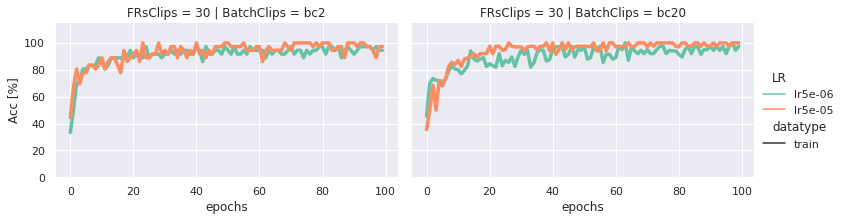

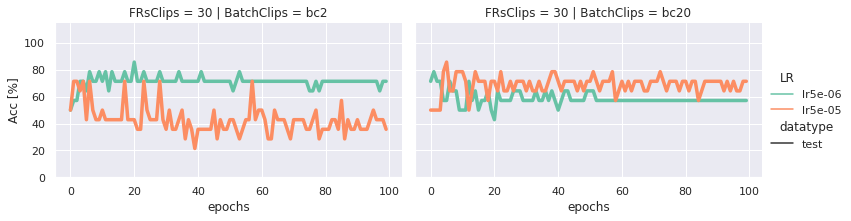

In [3]:
def json2Frame(PATH, FILENAME,BatchClips,LR,STR_VARIABLE_NAME):
    FULL_PATH_FILENAME = os.path.join(PATH, FILENAME)
    df=pd.read_json(FULL_PATH_FILENAME,orient='columns')
    DFDICT = pd.DataFrame.from_dict(df).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    DFDICT.insert(1, 'LR', 'lr'+str(LR), True)
    DFDICT.insert(2, 'BatchClips', 'bc'+str(BatchClips), True)
    DFDICT.insert(3, 'FRsClips', str(30), True)
    DFDICT.rename(columns={"variable":"datatype"} ,inplace=True)
    DFDICT.rename(columns={"value":STR_VARIABLE_NAME} ,inplace=True)
    return DFDICT 

BatchClips_1=2
BatchClips_2=20
LEARNING_RATE_1=0.0000050000
LEARNING_RATE_2=0.0000500000
STR_VARIABLE_NAME = 'Acc [%]'

acc_df0=json2Frame(TRAINING_CURVES_PATH,str(json_files[0]),BatchClips_1,LEARNING_RATE_1, STR_VARIABLE_NAME)
acc_df1=json2Frame(TRAINING_CURVES_PATH,str(json_files[1]),BatchClips_1,LEARNING_RATE_2, STR_VARIABLE_NAME)
acc_df3=json2Frame(TRAINING_CURVES_PATH,str(json_files[2]),BatchClips_2,LEARNING_RATE_1, STR_VARIABLE_NAME)
acc_df4=json2Frame(TRAINING_CURVES_PATH,str(json_files[3]),BatchClips_2,LEARNING_RATE_2, STR_VARIABLE_NAME)
acc_dfall = [acc_df0, acc_df1,acc_df3,acc_df4]
acc_all = pd.concat(acc_dfall)
print(acc_all)

sns.set(style="darkgrid")#sns.set(style="ticks")
g0=sns.relplot(x="epochs", y=STR_VARIABLE_NAME, 
            hue="LR",
            col="BatchClips", 
            row="FRsClips", 
            style="datatype",
            #col_wrap=2, 
            height=3, aspect=1.75, linewidth=3.5,
            kind="line", 
            estimator=None,
            palette="Set2",#palette=palette,
            data=acc_all.query("datatype == 'train'"))#data=acc_all)
g0.set(ylim=(0, 115))

sns.set(style="darkgrid")
g1=sns.relplot(x="epochs", y=STR_VARIABLE_NAME, 
            hue="LR",
            col="BatchClips", 
            row="FRsClips", 
            style="datatype",
            #col_wrap=2, 
            height=3, aspect=1.75, linewidth=3.5,
            kind="line", 
            estimator=None,
            palette="Set2",#palette=palette,
            data=acc_all.query("datatype == 'test'"))#data=acc_all)
g1.set(ylim=(0, 115))

plt.show()



     epochs       LR BatchClips FRsClips datatype      Loss
0         0  lr5e-06        bc2       30    train  1.148886
1         1  lr5e-06        bc2       30    train  0.715700
2         2  lr5e-06        bc2       30    train  0.656283
3         3  lr5e-06        bc2       30    train  0.625130
4         4  lr5e-06        bc2       30    train  0.611015
..      ...      ...        ...      ...      ...       ...
195      95  lr5e-05       bc20       30     test  0.921074
196      96  lr5e-05       bc20       30     test  1.010569
197      97  lr5e-05       bc20       30     test  1.264931
198      98  lr5e-05       bc20       30     test  0.882667
199      99  lr5e-05       bc20       30     test  0.884413

[800 rows x 6 columns]


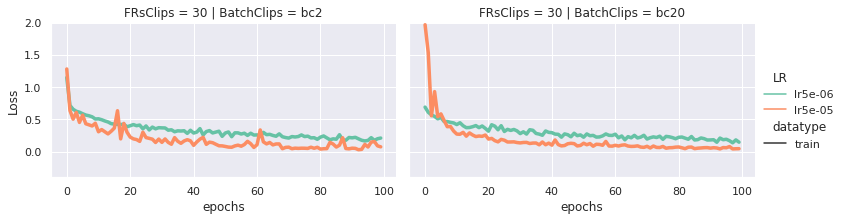

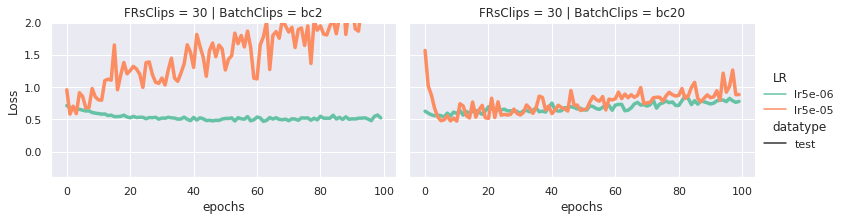

In [4]:
STR_VARIABLE_NAME = 'Loss'

loss_df0=json2Frame(TRAINING_CURVES_PATH,str(json_files[4]),BatchClips_1,LEARNING_RATE_1,STR_VARIABLE_NAME)
loss_df1=json2Frame(TRAINING_CURVES_PATH,str(json_files[5]),BatchClips_1,LEARNING_RATE_2,STR_VARIABLE_NAME)
loss_df3=json2Frame(TRAINING_CURVES_PATH,str(json_files[6]),BatchClips_2,LEARNING_RATE_1,STR_VARIABLE_NAME)
loss_df4=json2Frame(TRAINING_CURVES_PATH,str(json_files[7]),BatchClips_2,LEARNING_RATE_2,STR_VARIABLE_NAME)
loss_dfall = [loss_df0, loss_df1, loss_df3, loss_df4]
loss_all = pd.concat(loss_dfall)
print(loss_all)

sns.set(style="darkgrid")#sns.set(style="ticks")
g2=sns.relplot(x="epochs", y=STR_VARIABLE_NAME, 
            hue="LR",
            col="BatchClips", 
            row="FRsClips", 
            style="datatype",
            #col_wrap=2, 
            height=3, aspect=1.75, linewidth=3.5,
            kind="line", 
            estimator=None,
            palette="Set2",#palette=palette,
            data=loss_all.query("datatype == 'train'"))#data=acc_all)
g2.set(ylim=(-0.4, 2))


sns.set(style="darkgrid")
g3=sns.relplot(x="epochs", y=STR_VARIABLE_NAME, 
            hue="LR",
            col="BatchClips", 
            row="FRsClips", 
            style="datatype",
            #col_wrap=2, 
            height=3, aspect=1.75, linewidth=3.5,
            kind="line", 
            estimator=None,
            palette="Set2",#palette=palette,
            data=loss_all.query("datatype == 'test'"))#data=acc_all)
g3.set(ylim=(-0.4, 2))

plt.show()
